### Import and authentification

In [1]:
import ee 
import folium
from datetime import datetime as dt
from IPython.display import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

In [ ]:
ee.Initialize()
ee.Authenticate()

### Global variables

In [3]:
import os
from google.cloud import storage

BUCKET = 'forest_guard_bucket'  # ⚠️ replace with your BUCKET NAME
FOLDER = 'JP_data_forest_guards'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

OPTICAL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
THERMAL_BANDS = ['B10', 'B11']
BANDS = OPTICAL_BANDS + THERMAL_BANDS
RESPONSE = 'fnf'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Specify model training parameters.
#BATCH_SIZE = 16
# EPOCHS = 10
#BUFFER_SIZE = 2000
# OPTIMIZER = 'SGD'
# LOSS = 'MeanSquaredError'
# METRICS = ['RootMeanSquaredError']
   

### Data

#### X

In [4]:
from forest_guard.datas import get_image_landsat

# The image input data is a cloud-masked median composite.
image = get_image_landsat('2015-01-01', '2017-12-31')


# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[48.9, 2.5])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
    opacity = 0.5
  ).add_to(map)

mapid = image.getMapId({'bands': ['B11'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
    opacity = 0.5
  ).add_to(map)
map.add_child(folium.LayerControl())
map

#### Target

In [5]:
from forest_guard.datas import get_jaxa
jaxa = get_jaxa('2017-01-01', '2017-12-31')

palette = ['006400',
           'FEFF99',
            '0000FF'
          ]
mapid = jaxa.getMapId({'bands': ['fnf'],
                       'min': 1, 
                       'max': 3, 
                      'palette':palette
                      })
map = folium.Map(location=[48.9, 2.5])


folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='jaxa fnf',
    color=palette,
    opacity = 1
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Stacking X and y

In [6]:
from forest_guard.datas import get_stacked_arrays

arrays = get_stacked_arrays(image, jaxa, BANDS, RESPONSE, KERNEL_SIZE)

### Areas of interests

In [7]:
# create our own areas of interests
# training features collection
rect_train = ee.Geometry.Rectangle([3.327248985602229, 46.600827791084875, 4.689553673102229,47.70649093701327])
trainingPolys = ee.FeatureCollection([rect_train])
# eval features collections
rect_eval = ee.Geometry.Rectangle([-0.7016469211726672,46.88962161312492, 0.9353159694523328,47.64998631126759])
evalPolys= ee.FeatureCollection([rect_eval])

In [8]:
###################################################
###   DEFINE OUR COLLECTSIONS OF AREAS OF INTEREST
################################################

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
map = folium.Map(location=[47., 0.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Export data TFRecords

In [9]:
from forest_guard.datas import export_to_cloud_sampling_train_eval


export_to_cloud_sampling_train_eval(trainingPolys, evalPolys, arrays, 2, 20, FOLDER)

{'state': 'READY', 'description': 'eval_patches_g0', 'creation_timestamp_ms': 1622040441593, 'update_timestamp_ms': 1622040441593, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'UZHJVYEA66XMCHGCNR2NNWV7', 'name': 'projects/earthengine-legacy/operations/UZHJVYEA66XMCHGCNR2NNWV7'}
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
{'state': 'COMPLETED', 'description': 'eval_patches_g0', 'creation_timestamp_ms': 1622040441593, 'update_timestamp_ms': 1622040463784, 'start_timestamp_ms': 1622040457167, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://console.developers.google.com/storage/browser/forest_guard_bucket/JP_data_forest_guards/'], 'attempt': 1, 'id': 'UZHJVYEA66XMCHGCNR2NNWV7', 'name': 'projects/earthengine-legacy/operations/UZHJVYEA66XMCHGCNR2NNWV7'}


### Parse TFRecords and get back tensors

In [10]:
from forest_guard.parse import get_training_dataset

training = get_training_dataset(FOLDER)

print(iter(training.take(1)).next())

(<tf.Tensor: shape=(16, 256, 256, 9), dtype=float32, numpy=
array([[[[0.0281 , 0.0355 , 0.06985, ..., 0.12   , 0.1685 , 0.152  ],
         [0.0281 , 0.0355 , 0.06985, ..., 0.12   , 0.1685 , 0.152  ],
         [0.0288 , 0.0372 , 0.0733 , ..., 0.1202 , 0.1655 , 0.1495 ],
         ...,
         [0.02535, 0.03385, 0.0728 , ..., 0.1059 , 0.1745 , 0.1585 ],
         [0.0233 , 0.0327 , 0.0634 , ..., 0.107  , 0.1795 , 0.1665 ],
         [0.02705, 0.0376 , 0.0707 , ..., 0.12215, 0.172  , 0.159  ]],

        [[0.0273 , 0.0338 , 0.0649 , ..., 0.1132 , 0.1625 , 0.1495 ],
         [0.0273 , 0.0338 , 0.0649 , ..., 0.1132 , 0.1625 , 0.1495 ],
         [0.0283 , 0.0351 , 0.0707 , ..., 0.1164 , 0.1635 , 0.1495 ],
         ...,
         [0.02375, 0.03235, 0.065  , ..., 0.1084 , 0.175  , 0.1585 ],
         [0.01985, 0.02605, 0.0539 , ..., 0.09895, 0.174  , 0.1585 ],
         [0.02755, 0.03645, 0.06885, ..., 0.1215 , 0.172  , 0.159  ]],

        [[0.0228 , 0.0273 , 0.054  , ..., 0.0829 , 0.1595 , 0.1475 ]

In [11]:
images , labels = iter(training.take(1)).next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


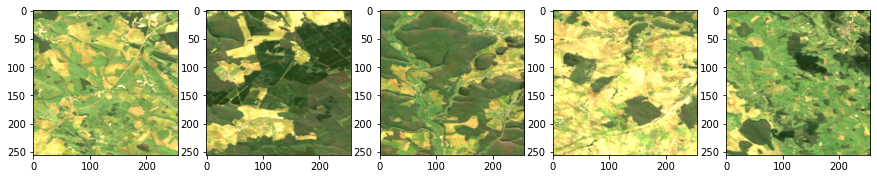

In [12]:
fig = plt.figure(figsize=(15,7))

for i in range(5):
    plt.subplot(1, 5, i+1 )
    plt.imshow(np.flip(images[i, :, : , 1:4].numpy(), axis=2)*10)
    

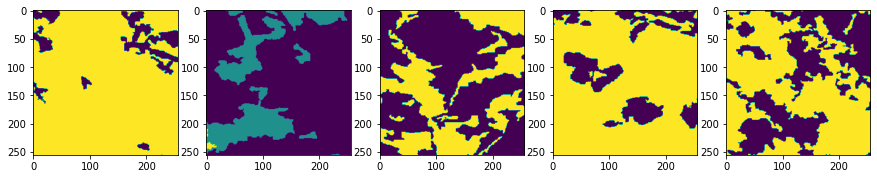

In [13]:
fig = plt.figure(figsize=(15,7))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(labels[i, :, : , :])


In [14]:
from forest_guard.parse import get_eval_dataset

In [15]:
evaluation = get_eval_dataset(FOLDER)

In [16]:
print(iter(evaluation.take(1)).next())

(<tf.Tensor: shape=(16, 256, 256, 9), dtype=float32, numpy=
array([[[[0.0338    , 0.045     , 0.07755   , ..., 0.1227    ,
          0.2105    , 0.1865    ],
         [0.03465   , 0.04465   , 0.0803    , ..., 0.1268    ,
          0.207     , 0.1845    ],
         [0.0336    , 0.0431    , 0.0732    , ..., 0.1264    ,
          0.1995    , 0.1805    ],
         ...,
         [0.0354    , 0.0491    , 0.0914    , ..., 0.1256    ,
          0.1915    , 0.1635    ],
         [0.0378    , 0.0527    , 0.1003    , ..., 0.1287    ,
          0.1915    , 0.1625    ],
         [0.0378    , 0.0527    , 0.1003    , ..., 0.1287    ,
          0.1915    , 0.1625    ]],

        [[0.0302    , 0.03905   , 0.07295   , ..., 0.11715   ,
          0.202     , 0.1815    ],
         [0.02655   , 0.03265   , 0.06085   , ..., 0.09475   ,
          0.1975    , 0.1785    ],
         [0.0244    , 0.0297    , 0.0523    , ..., 0.0821    ,
          0.1945    , 0.1745    ],
         ...,
         [0.0381    , 0.0511